Pre-processing of data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import nltk
from word2number import w2n
from owlready2 import *

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [2]:


# Load ontology from a given IRI (file or URL)
onto = get_ontology("Gold_standard_Ontology").load()

labels = []

# loop through each class in the ontology
for cls in onto.classes():
    # if the class has labels
    if cls.label:
        # append the labels to the list
        labels.extend(cls.label)

# write the labels to a text file
with open('gold_standard_classes.txt', 'w') as f:
    for item in labels:
        f.write("%s\n" % item)


In [3]:
sentences = []

with open('gold_standard_classes.txt', 'r') as file:
    for line in file:
        sentence = line.rstrip('.\n')  
        sentences.append(sentence)

sentences = list(set(sentences))

Sentence embeddings

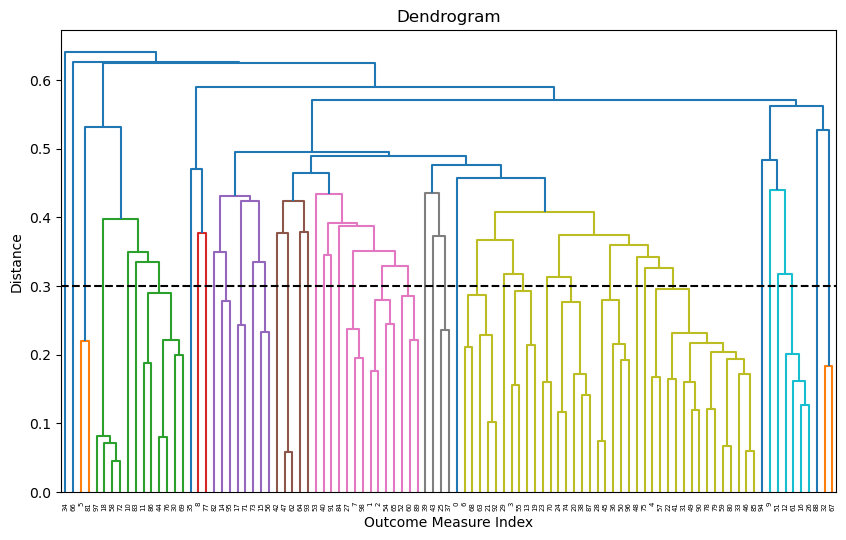

In [4]:
# Define the predefined labels
labels = ["Measure of quality of life",
    "Measure of patient satisfaction",
    "Measure of tolerability",
    "Measure of adherence",
    "Measure of costs",
    "Measure of efficacy",
    "Measure of healthcare resource utilization",
    "Measure of neurocognitive function",
    "Measure of nutritional status",
    "Measure of patient preference",
    "Measure of performance status",
    "Measure of sexual function",
    "Measure of safety"]


# Cluster the data using sentence embeddings and hierarchial clustering
model = SentenceTransformer('bert-base-nli-mean-tokens')
outcome_measures = sentences  # Convert the outcome measure sentences to a list
sentence_embeddings = model.encode(outcome_measures)
Z = linkage(sentence_embeddings, metric='cosine', method='average')

plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.axhline(y=0.3, color='k', linestyle='--')  # Add this line
plt.xlabel('Outcome Measure Index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.savefig('dendrogram2.png', dpi=300, format='png')
plt.show()




In [5]:
cutoff_height = 0.3  # Determine the cutoff height based on the dendrogram analysis
clusters = fcluster(Z, t=cutoff_height, criterion='distance')

outcome_measures_clustered = pd.DataFrame({'Outcome Measure': outcome_measures, 'Cluster': clusters})

Topic modeling 

In [8]:
# Determine the topics of each cluster using LDA
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(outcome_measures)
lda_model = LatentDirichletAllocation(n_components=13, random_state=0)
lda_model.fit(X)
topics = lda_model.transform(X)

# Extract keywords or representative terms from each topic using the top 5 words with the highest probabilities
feature_names = vectorizer.get_feature_names_out()
keywords_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    keywords_per_topic.append([feature_names[i] for i in topic.argsort()[:-6:-1]])

# Calculate similarity between the extracted keywords and the predefined labels using BERT embeddings and cosine similarity
label_embeddings = model.encode(labels)
similarity_scores_per_cluster = []
for cluster_id in outcome_measures_clustered['Cluster'].unique():
    cluster_topic_idx = topics[outcome_measures_clustered[outcome_measures_clustered['Cluster'] == cluster_id].index[0]].argmax()
    cluster_keywords = keywords_per_topic[cluster_topic_idx]
    cluster_keywords_embedding = model.encode(cluster_keywords)
    cluster_keywords_embedding_mean = np.mean(cluster_keywords_embedding, axis=0)
    similarity_scores_per_cluster.append(cosine_similarity([cluster_keywords_embedding_mean], label_embeddings)[0])

# Assign labels based on the highest similarity score and a threshold of 0.5
label_threshold = 0.5

labels_per_outcome = []
for cluster_id in outcome_measures_clustered['Cluster']:
    similarity_scores = similarity_scores_per_cluster[cluster_id-1]
    max_score_idx = similarity_scores.argmax()
    max_score = similarity_scores[max_score_idx]
    if max_score > label_threshold:
        labels_per_outcome.append(labels[max_score_idx])
    else:
        labels_per_outcome.append("No match")




# Add the labels column to the outcome_measures_clustered dataframe
outcome_measures_clustered['Label'] = labels_per_outcome


# Merge the clusters using the pandas concat function
merged_clusters = pd.concat([outcome_measures_clustered.groupby('Label')['Outcome Measure'].agg(list), outcome_measures_clustered.groupby('Label').size()], axis=1).reset_index()
merged_clusters.columns = ['Label', 'Outcome Measure', 'Size']

# Print the merged clusters
merged_clusters

,Label,Outcome Measure,Size
0,Measure of costs,"[Lesion size, Long Term Health-Related Quality...",91
1,Measure of performance status,"[Time to progression, Treatment response, Time...",3
2,Measure of tolerability,"[Hematologic toxicity, Cardiac toxicity, Porto...",5


In [7]:
# Prepare data for LDA
vectorizer_outcome = CountVectorizer()
vectorizer_labels = CountVectorizer()

X_outcome = vectorizer_outcome.fit_transform(outcome_measures)
X_labels = vectorizer_labels.fit_transform(labels)

# Fit LDA models
lda_model_outcome = LatentDirichletAllocation(n_components=13, random_state=0)
lda_model_outcome.fit(X_outcome)
topics = lda_model_outcome.transform(X_outcome)

lda_model_labels = LatentDirichletAllocation(n_components=len(labels), random_state=0)  # assuming each label represents a different topic
lda_model_labels.fit(X_labels)

# Extract keywords from outcome measures
feature_names_outcome = vectorizer_outcome.get_feature_names_out()
keywords_per_topic_outcome = []
for topic_idx, topic in enumerate(lda_model_outcome.components_):
    keywords_per_topic_outcome.append([feature_names_outcome[i] for i in topic.argsort()[:-6:-1]])

# Extract keywords from labels
feature_names_labels = vectorizer_labels.get_feature_names_out()
keywords_per_topic_labels = []
for topic_idx, topic in enumerate(lda_model_labels.components_):
    keywords_per_topic_labels.append([feature_names_labels[i] for i in topic.argsort()[:-6:-1]])

# Calculate similarity between the extracted keywords from outcomes and labels
similarity_scores_per_cluster = []
for cluster_id in outcome_measures_clustered['Cluster'].unique():
    cluster_topic_idx = topics[outcome_measures_clustered[outcome_measures_clustered['Cluster'] == cluster_id].index[0]].argmax()
    cluster_keywords = keywords_per_topic_outcome[cluster_topic_idx]
    cluster_keywords_embedding = model.encode(cluster_keywords)
    cluster_keywords_embedding_mean = np.mean(cluster_keywords_embedding, axis=0)
    
    label_similarity_scores = []
    for label_keywords in keywords_per_topic_labels:
        label_keywords_embedding = model.encode(label_keywords)
        label_keywords_embedding_mean = np.mean(label_keywords_embedding, axis=0)
        label_similarity_scores.append(cosine_similarity([cluster_keywords_embedding_mean], [label_keywords_embedding_mean])[0][0])

    similarity_scores_per_cluster.append(label_similarity_scores)

# Assign labels based on the highest similarity score and a threshold of 0.5
label_threshold = 0.5

labels_per_outcome = []
for cluster_id in outcome_measures_clustered['Cluster']:
    similarity_scores = np.array(similarity_scores_per_cluster[cluster_id-1])
    max_score_idx = similarity_scores.argmax()
    max_score = similarity_scores[max_score_idx]
    if max_score > label_threshold:
        labels_per_outcome.append(labels[max_score_idx])
    else:
        labels_per_outcome.append("No match")

# Add the labels column to the outcome_measures_clustered dataframe
outcome_measures_clustered['Label'] = labels_per_outcome

# Merge the clusters using the pandas concat function
merged_clusters = pd.concat([outcome_measures_clustered.groupby('Label')['Outcome Measure'].agg(list), outcome_measures_clustered.groupby('Label').size()], axis=1).reset_index()
merged_clusters.columns = ['Label', 'Outcome Measure', 'Size']

# Print the merged clusters
merged_clusters


,Label,Outcome Measure,Size
0,Measure of efficacy,"[Time to pain progression, State-trait anxiety...",24
1,Measure of performance status,"[Cold pain thresholds, Duration of response, O...",67
2,Measure of quality of life,"[Change in fat free mass, Long Term Health-Rel...",4
3,Measure of sexual function,"[Clinical benefit rate, Anti-Drug antibodies i...",4


Exporting it as an ontology

In [8]:
from owlready2 import *
import types
import re

# Create a new ontology
lastontology = get_ontology("http://example.com/lastontology.owl")

# List of desired class labels
desired_labels = [
    "Measure of quality of life",
    "Measure of patient satisfaction",
    "Measure of tolerability",
    "Measure of adherence",
    "Measure of costs",
    "Measure of efficacy",
    "Measure of healthcare resource utilization",
    "Measure of neurocognitive function",
    "Measure of nutritional status",
    "Measure of patient preference",
    "Measure of performance status",
    "Measure of sexual function",
    "Measure of safety",
]

with lastontology:
    # For each desired label
    for label in desired_labels:
        # Clean up the label name to be a valid class name
        label_class_name = re.sub('\W|^(?=\d)','_', label)
        # Create a new OWL class for this label
        LabelClass = types.new_class(label_class_name, (Thing,))
        # Append original label name as rdfs:label
        LabelClass.label.append(label)
        # Get the outcome measures for this label
        cluster_outcomes = merged_clusters[merged_clusters['Label'] == label]['Outcome Measure']
        # For each outcome measure list
        for outcome_list in cluster_outcomes:
            # For each outcome in the list
            for outcome in outcome_list:
                # Clean up the outcome name to be a valid class name
                outcome_class_name = re.sub('\W|^(?=\d)','_', outcome)
                # Create a new OWL class for this outcome measure, as a subclass of LabelClass
                OutcomeClass = types.new_class(outcome_class_name, (LabelClass,))
                # Append original outcome name as rdfs:label
                OutcomeClass.label.append(outcome)

# Save the ontology to an OWL file
lastontology.save(file = "automatic_ontology_3.owl", format = "rdfxml")
